## Fine-tuning Visualisation notebook

Notebook that creates all visualisations used in the report.

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import re
from collections import Counter
import random
import torch
#Importing relevant libraries
import numpy as np
import pandas as pd
import torch
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import random
import os
import re
import json

def preprocess_provo_corpus(provo):
    """Reading the raw Provo Corpus dataset and create a dictionary with all useful
    information we might need from it"""
    predict_norms = pd.read_csv(provo, sep='\t')
    paragraphs = predict_norms.groupby('Text_ID')['Text'].max()

    provo_processed = {}
    count = 0
    for text_id in range(1,56): #iterate over all provo paragraphs
        for word_num in predict_norms[predict_norms['Text_ID'] == text_id]['Word_Number'].unique(): #iterating over all words in each text
            word_dist = predict_norms[(predict_norms['Text_ID'] == text_id) & (predict_norms['Word_Number'] == word_num)]
            unique_human_words = word_dist['Response'].unique() #all human answered words for each context
            unique_word_dist = []
            for word in unique_human_words:
                unique_word_count = sum(word_dist[word_dist['Response'] == word]['Response_Count']) #getting all counts of the unique word and summing them
                unique_word_dist.append((word, unique_word_count))

            provo_processed[count] = {}
            provo_processed[count]['context_with_original_word'] = paragraphs[text_id].split(' ')[:int(word_num)]
            provo_processed[count]['context'] = paragraphs[text_id].split(' ')[:(int(word_num)-1)]
            provo_processed[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
            provo_processed[count]['human_next_word_pred'] = unique_word_dist

            count = count + 1

    return provo_processed

# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/nlp2_project
# %ls

input_data = os.path.join(os.getcwd(), 'Provo_Corpus.tsv')
data = preprocess_provo_corpus(input_data)

def get_estimator(elements):
    """Get the MLE estimate given all words (probability of a word equals its relative frequency)"""
    c = Counter(elements)
    support = list(c.keys())
    counts = list(c.values())
    probs = [count / sum(counts) for count in counts]

    return (support, probs)

def get_common_support(support1, support2):
    """Receives supports from two distributions and return all elements appearing in at least one of them"""
    return set(support1).union(set(support2))

def change_support(old_support, old_probs, new_support):
    """Create new support by adding elements to a support that did not exist before
     (hence, their probability value is 0)"""
    new_probs = []
    for item in new_support:
        if item in old_support:
            ind = old_support.index(item)
            new_probs.append(old_probs[ind])
        else:
            new_probs.append(0)
    return list(new_support), new_probs

def get_tvd(probs1, probs2):
    """Receives the probabilities of 2 distributions to compare and returns their TVD (Total Variation Distance)"""
    tvd = np.sum(np.abs(np.array(probs1) - np.array(probs2)))/2

    return tvd

def get_oracle_elements(words, seed = 0):
    """We receive a list of words and we create two disjoint subsets
    from it by sampling without replacement from them.
    We return the two disjoint sets of words"""
    random.seed(seed)

    #if the length of the list is odd, we remove one element at random to make the list even,
    #to ensure the two disjoint subsets are of equal length
    if (len(words) % 2 == 1):
        remove_word = random.sample(words, 1)
        words.remove(remove_word[0])

    #We sample the words that will belong in the first subset and create the second subset by removing
    #from the full word list the ones sampled in the first subset
    subset1 = random.sample(words, len(words)//2)
    subset2 = words.copy()
    for item in subset1:
        subset2.remove(item)

    return subset1, subset2

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
# #Switching to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token

# model = GPT2LMHeadModel.from_pretrained("gpt2")

def get_model_samples(model, tokenizer, context, n_samples = 5, add_tokens = 5, seed = 0, pad_token = '<|endoftext|>', top_k = 0):
    """Given a context we return the words that were generated during ancestral sampling for n_samples"""
    inputs_ids = tokenizer(context, return_tensors="pt")['input_ids']
    inputs_ids.to(device)
    torch.manual_seed(seed)
    # outputs = model.generate(inputs_ids, do_sample=True, num_beams = 1, num_return_sequences= n_samples,
    #                          max_new_tokens = add_tokens, pad_token_id = pad_token, top_k= top_k)
    outputs = model.generate(inputs_ids, do_sample=True, num_beams = 1, num_return_sequences= n_samples,
                             max_new_tokens = add_tokens) #This samples unbiasedly from the next-token distribution of the model for add_tokens tokens, n_samples times

    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    #Remove context to keep only generated text
    outputs = [x.replace(context + ' ', '').replace(context, '').replace('\n', '') for x in outputs]
    #Remove punctuation
    outputs = [re.sub(r'[^\w\s]', '', x) for x in outputs] #removing punctuation
    list_of_words = [x.split(' ') for x in outputs]

    # print(f'len outputs = {len(list_of_words)}')

    sampled_words = []
    for generation in list_of_words:
        if set(generation) == {''}:
            sampled_words.append('Failed to generate word')
        else:
            sampled_words.append(next(x.lower() for x in generation if x))

    return sampled_words

# generating k_fold data split
import math
def entropy(probabilities):
    """
    Calculate the entropy of a probability distribution.

    Args:
    - probabilities (list): List of probabilities representing a probability distribution.

    Returns:
    - float: Entropy value in bits.
    """
    entropy_value = 0.0

    # Calculate entropy using the formula
    for prob in probabilities:
        if prob > 0:  # Only consider non-zero probabilities to avoid log(0) which is undefined
            entropy_value -= prob * math.log2(prob)


    return entropy_value

data_dict = torch.load('data_dictionary.pt')
i_values = [5, 15, 25, 35]
k_fold_data = {0:{}, 1: {}, 2:{}, 3:{}}
k = 0
for i in i_values:
    train_data_small = {k: v for k, v in data_dict.items() if v['paragraph_num'] < i} # 0:i
    val_data_small = {k: v for k, v in data_dict.items() if v['paragraph_num'] >= i and v['paragraph_num'] < i+10} # i : i+10
    train_data_small.update({k: v for k, v in data_dict.items() if v['paragraph_num'] >= i+10 and v['paragraph_num'] < 45}) #i+10 : 45
    test_data = {k: v for k, v in data_dict.items() if v['paragraph_num'] >= 45}

    k_fold_data[k]['train_data'] = train_data_small
    k_fold_data[k]['val_data'] = val_data_small
    k_fold_data[k]['test_data'] = test_data
    print(f'k_fold statistics \nk: {k}\ntrain: {len(train_data_small)}\nval: {len(val_data_small)}\ntest:{len(test_data)}\n')
    k += 1

for i, sample in enumerate(k_fold_data[0]['train_data'].keys()):
    human_probs = np.array([prob for _, prob in k_fold_data[0]['train_data'][sample]['human_next_word_pred']])
    he = entropy(human_probs)
    k_fold_data[0]['train_data'][sample]['human_entropy'] = he


h_entropies = []
h_entropies_large = []
train_data_small = {}
train_data_large = {}
data_entropy_split = {'small':{}, 'large':{}}
for i, sample in enumerate(k_fold_data[0]['train_data'].keys()):
    # print(k_fold_data[0]['train_data'][sample])

    if k_fold_data[0]['train_data'][sample]['human_entropy'] > 2.5:
        train_data_small[sample] = k_fold_data[0]['train_data'][sample]['human_entropy']

    if k_fold_data[0]['train_data'][sample]['human_entropy'] > 1.9:
        train_data_large[sample] = k_fold_data[0]['train_data'][sample]['human_entropy']


data_entropy_split['small']['train_data'] = train_data_small
data_entropy_split['small']['val_data'] = k_fold_data[0]['val_data']
data_entropy_split['small']['test_data'] = k_fold_data[0]['test_data']

data_entropy_split['large']['train_data'] = train_data_large
data_entropy_split['large']['val_data'] = k_fold_data[0]['val_data']
data_entropy_split['large']['test_data'] = k_fold_data[0]['test_data']

k_fold statistics 
k: 0
train: 1576
val: 541
test:570

k_fold statistics 
k: 1
train: 1629
val: 488
test:570

k_fold statistics 
k: 2
train: 1681
val: 436
test:570

k_fold statistics 
k: 3
train: 1693
val: 424
test:570



# Evaluation on train set

human human baseline on train set: 0.4187769880470646
human model baseline on train set: 0.5996005152916265
human FT model on train set: 0.5545815930934795
difference in tvd values: ft - model = -70.94982138427969
-0.04501892219814701


/tmp/ipykernel_398470/2457879023.py:94: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(subset['TVD'], label=f'Name {hue_level}', linestyle=line_styles[i], clip=(0,1), fill=True, palette = 'crest', alpha = 0.2, linewidth = 3)
/tmp/ipykernel_398470/2457879023.py:94: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(subset['TVD'], label=f'Name {hue_level}', linestyle=line_styles[i], clip=(0,1), fill=True, palette = 'crest', alpha = 0.2, linewidth = 3)
/tmp/ipykernel_398470/2457879023.py:94: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(subset['TVD'], label=f'Name {hue_level}', linestyle=line_styles[i], clip=(0,1), fill=True, palette = 'crest', alpha = 0.2, linewidth = 3)


Text(0.5, 1.0, 'TVD values on train set')

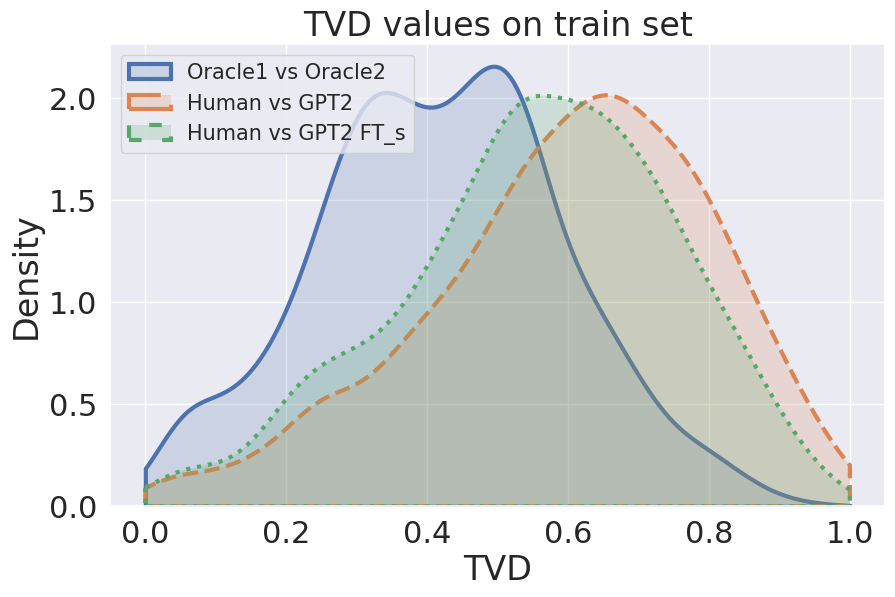

In [22]:
def plot_tvd_distributions(all_tvd_data, title='TVD Distributions', filename='tvd_distributions'):
    # Data Preparation for Plotting
    names = []
    tvd = []
    for name, values in all_tvd_data.items():
        names.extend([name] * len(values))
        tvd.extend(values)

    # Create a DataFrame
    df = pd.DataFrame({'Name': names, 'TVD': tvd})

    # Set Seaborn style and font size
    sns.set(rc={'figure.figsize': (10, 6)})
    sns.set(font_scale=2)
    plt.rcParams['font.family'] = 'Serif'
    plt.rcParams['font.size'] = 12
    # Set title size of plot

    # Define line styles
    line_styles = ['-', '--', ':', '-.', (0, (5, 10))]

    avg_tvds = []
    for name, values in all_tvd_data.items():
        # print(f'Average TVD {name}: {np.mean(np.array(values))}')
        avg = np.mean(np.array(values))
        # Round to 3 decimal places
        avg = round(avg, 3)
        avg_tvds.append(avg)
        # Round to 3 decimal places

    
    # Plotting
    for i, hue_level in enumerate(df['Name'].unique()):
        subset = df[df['Name'] == hue_level]
        sns.kdeplot(subset['TVD'], label=f'{hue_level}, $\mu$={avg_tvds[i]}', linestyle=line_styles[i % len(line_styles)], clip=(0, 1), fill=True, alpha=0.2, linewidth=3)

    # Add legend
    plt.title(title, fontsize=24)
    plt.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    # Save plot as PDF
    plt.savefig(f'{filename}.pdf', dpi=300, bbox_inches='tight')
    # Display the plot
    plt.show()

    # Print average TVDs
    print('---------------------------')
    for name, values in all_tvd_data.items():
        print(f'Average TVD {name}: {np.mean(np.array(values))}')
    
with open('results/tvd_values_fold0_trainset.json') as json_file:
    tvd_finetuned_train = json.load(json_file)


with open('results/tvd_values_baseline_trainset.json') as json_file:
    tvd_baseline_train = json.load(json_file)

# EVALUATION ON TRAIN SET (SANITY CHECK)
tvd_model_ft_train = tvd_finetuned_train["0"]["tvd_human_model"]
tvd_human_model_train =  tvd_baseline_train["tvd_human_model"]
tvd_human_human_train = tvd_baseline_train["tvd_human_human"]
print(f'human human baseline on train set: {np.mean(np.array( tvd_baseline_train["tvd_human_human"]))}')
print(f'human model baseline on train set: {np.mean(np.array( tvd_baseline_train["tvd_human_model"]))}')
print(f'human FT model on train set: {np.mean(np.array(tvd_finetuned_train["0"]["tvd_human_model"]))}')
diff_tvd_model_ft = np.sum( np.array(tvd_model_ft_train)-np.array(tvd_human_model_train) )
print(f'difference in tvd values: ft - model = {diff_tvd_model_ft}')
print(diff_tvd_model_ft/len(tvd_model_ft_train))
name_human_human = ['Oracle1 vs Oracle2']* len(tvd_model_ft_train)
name_human_model = ['Human vs GPT2']*len(tvd_model_ft_train)
name_human_model_ft0 = ['Human vs GPT2 FT_s']* len(tvd_model_ft_train)

names = [name_human_human, name_human_model, name_human_model_ft0]
# names = [name_human_human , name_human_model, name_human_model_ft0, name_human_model_ft1, name_human_model_ft2, name_human_model_ft3]
# names = [ name_human_model_ft0, name_human_model, name_human_human ]
tvd = [tvd_human_human_train,tvd_human_model_train, tvd_model_ft_train]
# tvd = [tvd_human_human, tvd_human_model, tvd_model_ft0 , tvd_model_ft1 , tvd_model_ft2 , tvd_model_ft3 ]
# tvd = [tvd_model_ft_train, tvd_human_model_train, tvd_human_human_train ]


names = [item for row in names for item in row]
tvd = [item for row in tvd for item in row]

dict = {'Name': names, 'TVD': tvd}
df = pd.DataFrame(dict)

sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=2)
line_styles = ['-', '--', ':', 'dashdot', '--', ':', 'dashdot']

# Loop through unique hue levels and create separate kdeplot for each
for i, hue_level in enumerate(df['Name'].unique()):
    subset = df[df['Name'] == hue_level]
    sns.kdeplot(subset['TVD'], label=f'Name {hue_level}', linestyle=line_styles[i], clip=(0,1), fill=True, palette = 'crest', alpha = 0.2, linewidth = 3)

plt.legend(labels=['Oracle1 vs Oracle2', 'Human vs GPT2', 'Human vs GPT2 FT_s'], loc='upper left', fontsize="15")
plt.title('TVD values on train set')
# plt.legend(labels=['human human', 'human gpt2', 'human model ft', 'human model ft1', 'human model ft2', 'human model ft3'], loc='upper left', fontsize="15")
# plt.savefig('TVD_all_models_plot.pdf', format="pdf",bbox_inches='tight')


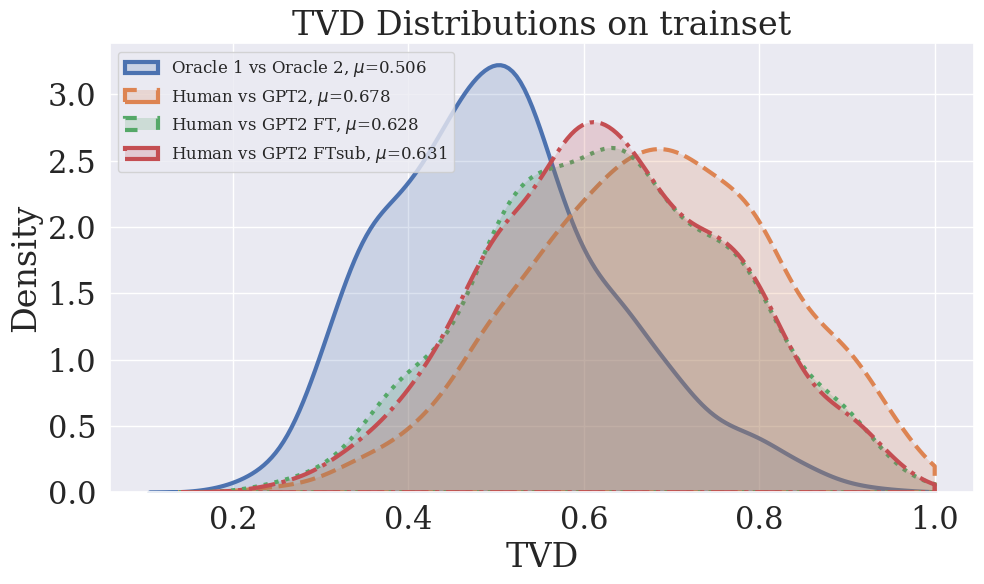

---------------------------
Average TVD Oracle 1 vs Oracle 2: 0.5059194040464222
Average TVD Human vs GPT2: 0.6781445239392409
Average TVD Human vs GPT2 FT: 0.6280901442116104
Average TVD Human vs GPT2 FTsub: 0.6312152050305814


In [23]:

# baseline on sub test
with open('results/baseline_subset_samples_train.json') as json_file:
    tvd_samples_baseline_subset = json.load(json_file)

tvd_baseline_subset_model = tvd_samples_baseline_subset['0']['tvd_human_model']
tvd_baseline_subset_human = tvd_samples_baseline_subset['0']['tvd_human_human']


# fts on sub set
with open('results/ft_s0_subset_samples_train.json') as json_file:
    tvd_fts_subset = json.load(json_file)

tvd_fts_subset_model = tvd_fts_subset['0']['tvd_human_model']

# ft_sub on sub set
with open('results/ft_rq3_tvd_samples_trainset.json') as json_file:
    tvd_ft3_subset = json.load(json_file)

tvd_ft3_subset_model = tvd_ft3_subset['0']['tvd_human_model']

all_tvd_data = {'Oracle 1 vs Oracle 2' : tvd_baseline_subset_human,
                'Human vs GPT2' : tvd_baseline_subset_model,
                'Human vs GPT2 FT': tvd_fts_subset_model,
                'Human vs GPT2 FTsub' : tvd_ft3_subset_model}

plot_tvd_distributions(all_tvd_data, title='TVD Distributions on trainset', filename='train_rq3_tvd_distributions')



# Data selection results


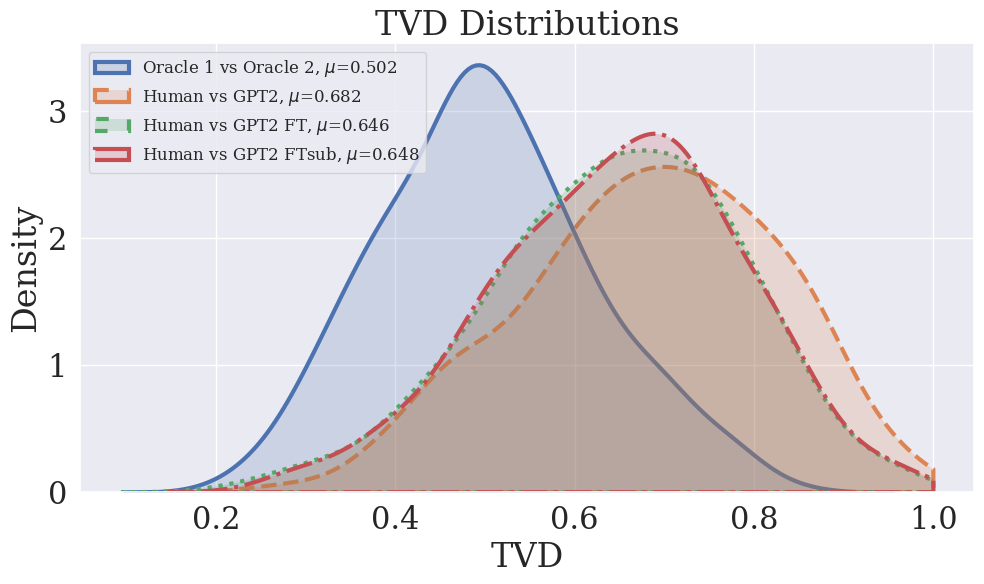

---------------------------
Average TVD Oracle 1 vs Oracle 2: 0.5015446701352205
Average TVD Human vs GPT2: 0.6820913490584122
Average TVD Human vs GPT2 FT: 0.6456531120261331
Average TVD Human vs GPT2 FTsub: 0.6483697756990991


In [25]:
# baseline on sub test
with open('results/baseline_subset_samples.json') as json_file:
    tvd_samples_baseline_subset = json.load(json_file)

tvd_baseline_subset_model = tvd_samples_baseline_subset['0']['tvd_human_model']
tvd_baseline_subset_human = tvd_samples_baseline_subset['0']['tvd_human_human']


# fts on sub set
with open('results/ft_s0_subset_samples.json') as json_file:
    tvd_fts_subset = json.load(json_file)

tvd_fts_subset_model = tvd_fts_subset['0']['tvd_human_model']

# ft_sub on sub set
with open('results/ft_rq3_tvd_samples.json') as json_file:
    tvd_ft3_subset = json.load(json_file)

tvd_ft3_subset_model = tvd_ft3_subset['0']['tvd_human_model']

all_tvd_data = {'Oracle 1 vs Oracle 2' : tvd_baseline_subset_human,
                'Human vs GPT2' : tvd_baseline_subset_model,
                'Human vs GPT2 FT': tvd_fts_subset_model,
                'Human vs GPT2 FTsub' : tvd_ft3_subset_model}

plot_tvd_distributions(all_tvd_data, title='TVD Distributions', filename='rq3_tvd_distributions')



# Quantitative analysis


Correlation Coefficient between avg TVD and unique_lengths: 0.5697240533387741
Correlation Coefficient between avg TVD and unique_entropy: 0.15286985644393705


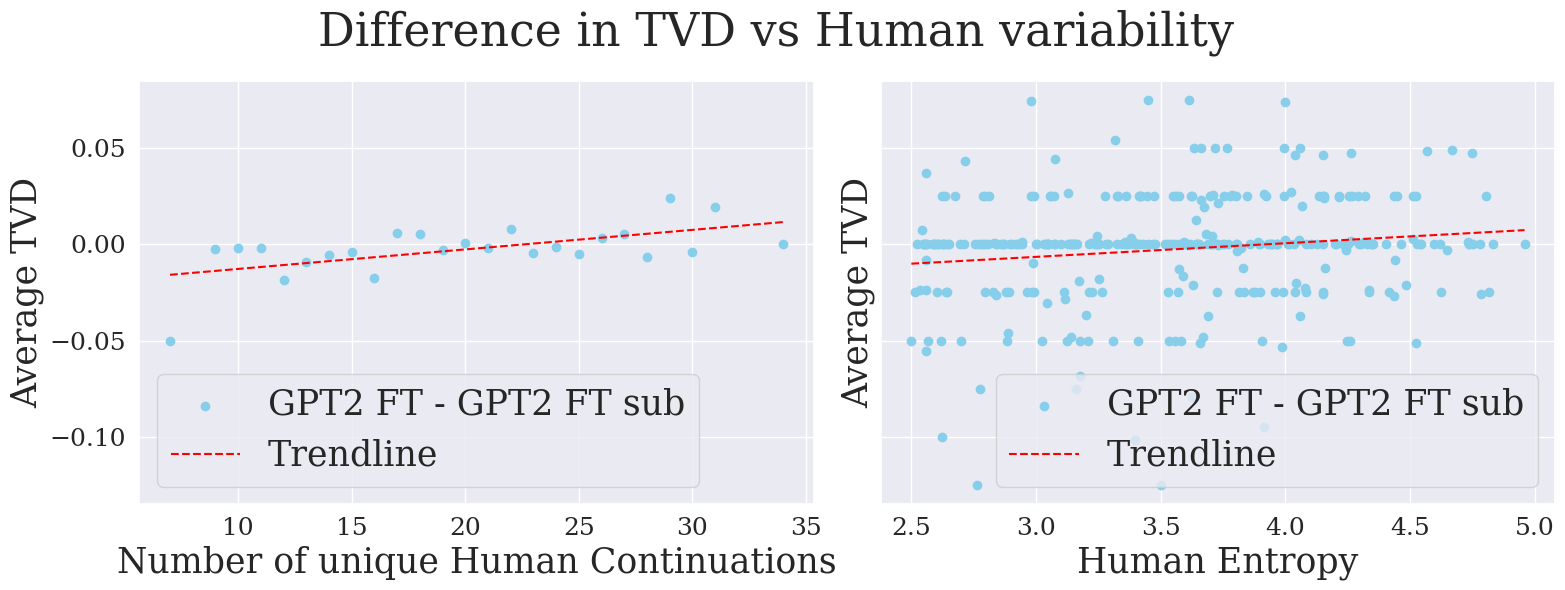

In [26]:
import json
import numpy as np
import matplotlib.pyplot as plt
import math


plt.rcParams["font.family"] = "serif"
plt.rcParams["hatch.color"] = "black"
# Function to calculate entropy
def entropy(probabilities):
    entropy_value = 0.0
    for prob in probabilities:
        if prob > 0:  # Only consider non-zero probabilities to avoid log(0) which is undefined
            entropy_value -= prob * np.log2(prob)
    return entropy_value

# Load TVD data
with open('results/ft_s0_subset_samples.json') as json_file:
    tvd_fts_subset = json.load(json_file)

tvd_fts_subset_model = tvd_fts_subset['0']['tvd_human_model']

with open('results/ft_rq3_tvd_samples.json') as json_file:
    tvd_ft3_subset = json.load(json_file)

tvd_ft3_subset_model = tvd_ft3_subset['0']['tvd_human_model']

# Assuming k_fold_data is already defined somewhere in your script

data_entropy_split = {0: {}, 1: {}, 2: {}, 3: {}}
for j in range(4):
    for i, sample in enumerate(k_fold_data[j]['train_data'].keys()):
        human_probs = np.array([prob for _, prob in k_fold_data[j]['train_data'][sample]['human_next_word_pred']])
        he = entropy(human_probs)
        k_fold_data[j]['train_data'][sample]['human_entropy'] = he
    
    for i, sample in enumerate(k_fold_data[j]['test_data'].keys()):
        human_probs = np.array([prob for _, prob in k_fold_data[j]['test_data'][sample]['human_next_word_pred']])
        he = entropy(human_probs)
        k_fold_data[j]['test_data'][sample]['human_entropy'] = he

    h_entropies = []
    train_data_small = {}
    test_data_small = {}

    for sample in k_fold_data[j]['train_data']:
        if k_fold_data[j]['train_data'][sample]['human_entropy'] > 2.5:
            train_data_small[sample] = k_fold_data[j]['train_data'][sample]
    
    for sample in k_fold_data[j]['test_data']:
        if k_fold_data[j]['test_data'][sample]['human_entropy'] > 2.5:
            test_data_small[sample] = k_fold_data[j]['test_data'][sample]
            
    data_entropy_split[j]['train_data'] = train_data_small
    data_entropy_split[j]['val_data'] = k_fold_data[j]['val_data']
    data_entropy_split[j]['test_data'] = test_data_small

test_data_entropy = data_entropy_split[0]['test_data']

context_lengths = np.array([len(test_data_entropy[x]["human_next_word_pred"]) for x in test_data_entropy])
tvd_differences = np.array(tvd_fts_subset_model) - np.array(tvd_ft3_subset_model)

# Find unique context lengths
unique_lengths = np.unique(context_lengths)

# Calculate average TVD for each unique context length
average_tvd_length = [np.mean(tvd_differences[context_lengths == length]) for length in unique_lengths]

# Fit a polynomial to the data points for context length
fit_coefficients_length = np.polyfit(unique_lengths, average_tvd_length, 1)
fit_function_length = np.poly1d(fit_coefficients_length)

# Calculate human entropies
h_entropy_entropy = [entropy(np.array([prob for _, prob in test_data_entropy[x]['human_next_word_pred']])) for x in test_data_entropy]

# Find unique entropy values
unique_entropy = np.unique(h_entropy_entropy)

# Calculate average TVD for each unique entropy value
average_tvd_entropy = [np.mean(tvd_differences[h_entropy_entropy == ent]) for ent in unique_entropy]

# Fit a polynomial to the data points for entropy
fit_coefficients_entropy = np.polyfit(unique_entropy, average_tvd_entropy, 1)
fit_function_entropy = np.poly1d(fit_coefficients_entropy)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
size = 25
# Plot for context lengths
ax1.scatter(unique_lengths, average_tvd_length, label='GPT2 FT - GPT2 FT sub', color='skyblue', marker='o')
ax1.plot(unique_lengths, fit_function_length(unique_lengths), color='red', linestyle='--', label='Trendline')
ax1.set_xlabel('Number of unique Human Continuations', fontsize=size)
ax1.set_ylabel('Average TVD', fontsize=size)
# ax1.set_title('Difference in TVD vs Human Variability', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.legend(fontsize=size)

correlation_matrix_length = np.corrcoef(average_tvd_length, unique_lengths)
correlation_coefficient_length = correlation_matrix_length[0, 1]
print(f"Correlation Coefficient between avg TVD and unique_lengths: {correlation_coefficient_length}")

# Plot for human entropy
ax2.scatter(unique_entropy, average_tvd_entropy, label='GPT2 FT - GPT2 FT sub', color='skyblue', marker='o')
ax2.plot(unique_entropy, fit_function_entropy(unique_entropy), color='red', linestyle='--', label='Trendline')
ax2.set_xlabel('Human Entropy', fontsize=size)
ax2.set_ylabel('Average TVD', fontsize=size)
# ax2.set_title('Difference in TVD vs Human Entropy', fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(fontsize=size)

correlation_matrix_entropy = np.corrcoef(average_tvd_entropy, unique_entropy)
correlation_coefficient_entropy = correlation_matrix_entropy[0, 1]
print(f"Correlation Coefficient between avg TVD and unique_entropy: {correlation_coefficient_entropy}")
fig.suptitle('Difference in TVD vs Human variability', fontsize=size+8)
plt.tight_layout()

plt.savefig('RQ3_analysis.pdf',format="pdf",bbox_inches='tight')
plt.show()


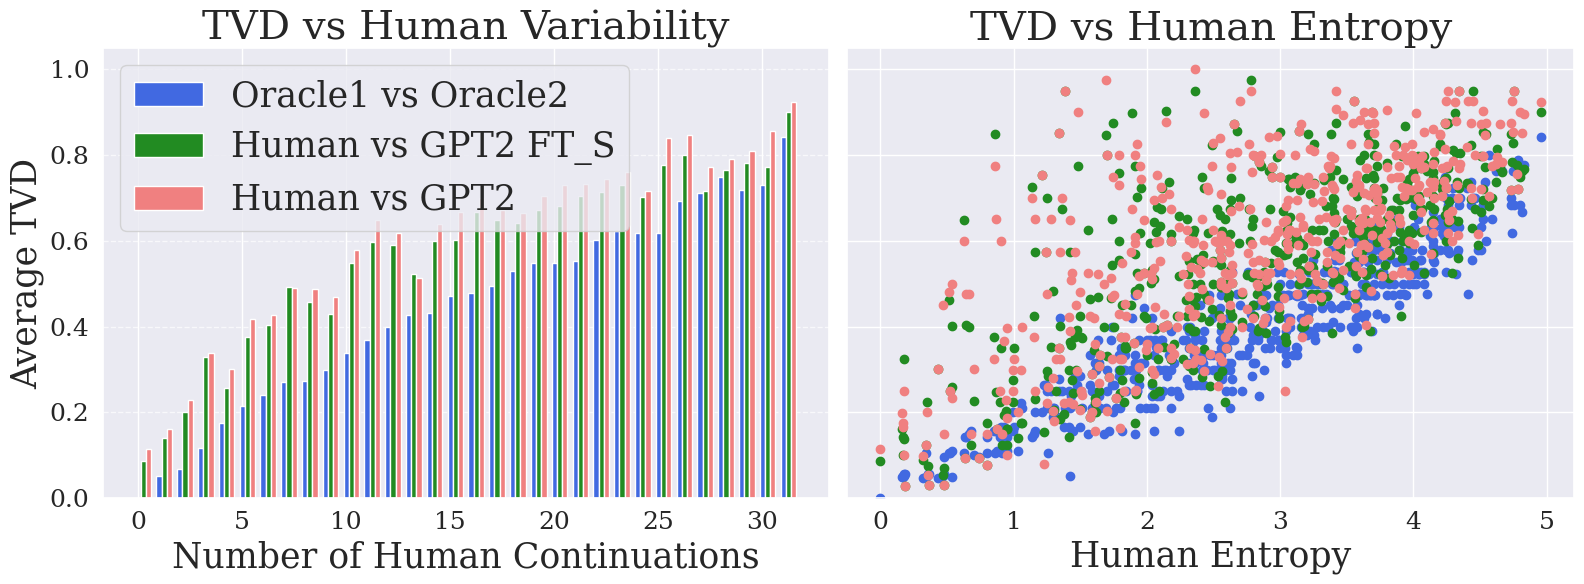

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Expected / avg TVD VALUES
with open('results/tvd_values_baseline.json') as json_file:
    tvd_baseline = json.load(json_file)

tvd_human_human = tvd_baseline['tvd_human_human']
tvd_human_model = tvd_baseline['tvd_human_model']

with open('results/gpt2_samples_tvd.json') as json_file:
    gpt2_samples_tvd = json.load(json_file)

gpt2_human_model_tvd_values = gpt2_samples_tvd['tvd_human_model']
gpt2_model_samples =  gpt2_samples_tvd['model_samples']


with open('results/tvd_values_kfold_finetunes.json') as json_file:
    tvd_finetuned = json.load(json_file)

diff_tvd_model_ft = np.sum( np.array(tvd_human_model)-np.array(gpt2_human_model_tvd_values) )

# get finetuned TVD values
tvd_model_ft0 = tvd_finetuned['0']['tvd_human_model']


# TVD MODEL FTL 0
with open('results/morelayers_tvd_samples.json') as json_file:
    tvd_ft = json.load(json_file)
tvd_model_ft_l = tvd_ft['0']['tvd_human_model']


# TVD MODEL FT lmhead 0
with open('results/ft_lmhead_tvd_samples.json') as json_file:
    tvd_ft = json.load(json_file)

tvd_model_ft_lmhead = tvd_ft['0']['tvd_human_model']

# Assuming k_fold_data, tvd_human_human, tvd_model_ft_l, and tvd_human_model are already defined

# Function to calculate entropy
def entropy(probabilities):
    entropy_value = 0.0
    for prob in probabilities:
        if prob > 0:  # Only consider non-zero probabilities to avoid log(0) which is undefined
            entropy_value -= prob * np.log2(prob)
    return entropy_value

# Prepare data for context lengths plot
test_data = k_fold_data[0]['test_data']
test_data_c_lens = []
test_data_next_words = []

for x in test_data.keys():
    test_data_next_words.append(len(test_data[x]["human_next_word_pred"]))
    test_data_c_lens.append(len(test_data[x]["context"]))

context_lengths = test_data_next_words

# Separate TVD values for different comparisons
tvd_human_human_values = np.array(tvd_human_human)
tvd_human_ft0_values = np.array(tvd_model_ft0)
tvd_human_model_values = np.array(tvd_human_model)

# Combine all TVD values
all_tvd_values = [tvd_human_human_values, tvd_human_ft0_values, tvd_human_model_values]
labels = ["Oracle1 vs Oracle2", "Human vs GPT2 FT_S", "Human vs GPT2"]
colors = ['royalblue', 'forestgreen', 'lightcoral']  # Colors for each scatter set

# Find unique context lengths
unique_lengths = np.unique(context_lengths)

# Calculate average TVD for each unique context length for all three types
average_tvd_length = [[np.mean(tvd_values[context_lengths == length]) for length in unique_lengths] for tvd_values in all_tvd_values]

# Prepare data for entropy plot
h_entropy = []
for x in test_data.keys():
    human_probs = np.array([prob for _, prob in test_data[x]['human_next_word_pred']])
    h_entropy.append(entropy(human_probs))

# Find unique entropy values
unique_entropy = np.unique(h_entropy)

# Calculate average TVD for each unique entropy value for all three types
average_tvd_entropy = [[np.mean(tvd_values[h_entropy == ent]) for ent in unique_entropy] for tvd_values in all_tvd_values]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
size = 25
# Plot for context lengths
bar_width = 0.25
index = np.arange(len(unique_lengths))
for i, (avg_tvd, color) in enumerate(zip(average_tvd_length, colors)):
    ax1.bar(index + i * bar_width, avg_tvd, bar_width, label=labels[i], color=color)
ax1.set_xlabel('Number of Human Continuations', fontsize=size)
ax1.set_ylabel('Average TVD', fontsize=size)
ax1.set_title('TVD vs Human Variability', fontsize=size+4)
ax1.legend(fontsize=size)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
# ax1.set_xticks(index + bar_width)
# ax1.set_xticklabels(unique_lengths)

# Plot for human entropy
for avg_tvd, label, color in zip(average_tvd_entropy, labels, colors):
    ax2.scatter(unique_entropy, avg_tvd, label=label, color=color, marker='o')
ax2.set_xlabel('Human Entropy', fontsize=size)
ax2.set_title('TVD vs Human Entropy', fontsize=size+4)
# ax2.legend(fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=18)
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()
plt.savefig('rq1a_basic_analysis.pdf', format='pdf')
plt.show()


# Research question 3

570
570
Correlation Coefficient between avg TVD and unique_lengths: 0.31254264901686746
Correlation Coefficient between avg TVD and unique_entropy: 0.036561776875917495


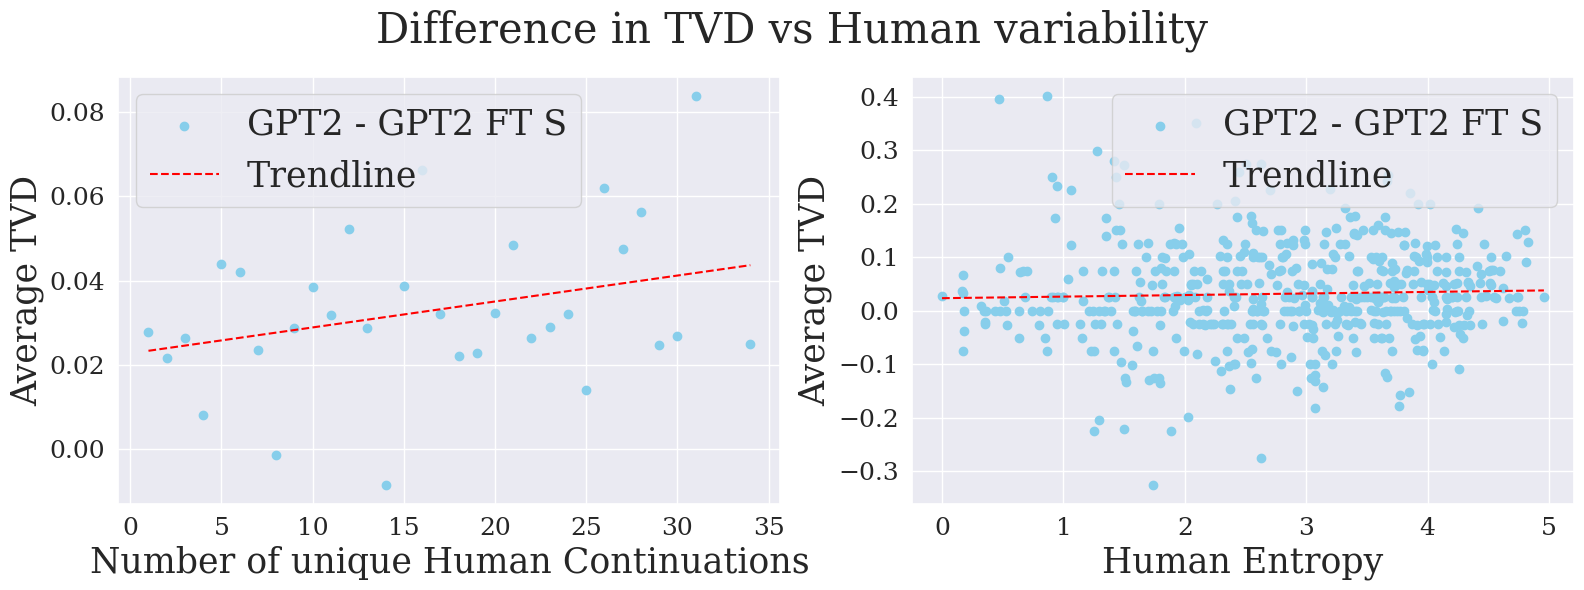

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
import math

# Function to calculate entropy
def entropy(probabilities):
    entropy_value = 0.0
    for prob in probabilities:
        if prob > 0:  # Only consider non-zero probabilities to avoid log(0) which is undefined
            entropy_value -= prob * np.log2(prob)
    return entropy_value

# i = 0

test_data_c_lens = []
test_data_next_words = []
h_entropy = []

tvd_model_ft0 = tvd_finetuned['0']['tvd_human_model']

with open('results/tvd_values_baseline.json') as json_file:
    tvd_baseline = json.load(json_file)

tvd_human_human = tvd_baseline['tvd_human_human']
tvd_human_model = tvd_baseline['tvd_human_model']

for x in test_data.keys():
    human_probs = np.array([prob for _, prob in test_data[x]['human_next_word_pred']])
    h_entropy.append(entropy(human_probs))

    test_data_next_words.append(len(test_data[x]["human_next_word_pred"]))
    test_data_c_lens.append(len(test_data[x]["context"]))
    human_probs = np.array([prob for _, prob in test_data[x]['human_next_word_pred']])
    h_entropy.append(entropy(human_probs))
with open('results/tvd_values_kfold_finetunes.json') as json_file:
    tvd_finetuned = json.load(json_file)

# diff_tvd_model_ft = np.sum( np.array(tvd_human_model)-np.array(gpt2_human_model_tvd_values) )

# get finetuned TVD values
tvd_model_ft0 = tvd_finetuned['0']['tvd_human_model']
tvd_differences = np.array(tvd_human_model)-np.array(tvd_model_ft0)
# tvd_differences = np.array(tvd_fts_subset_model) - np.array(tvd_ft3_subset_model)

context_lengths = test_data_next_words
# Find unique context lengths
unique_lengths = np.unique(context_lengths)

# Calculate average TVD for each unique context length
average_tvd_length = [np.mean(tvd_differences[context_lengths == length]) for length in unique_lengths]

# Fit a polynomial to the data points for context length
fit_coefficients_length = np.polyfit(unique_lengths, average_tvd_length, 1)
fit_function_length = np.poly1d(fit_coefficients_length)

# Calculate human entropies
h_entropy = [entropy(np.array([prob for _, prob in test_data[x]['human_next_word_pred']])) for x in test_data]

# Find unique entropy values
unique_entropy = np.unique(h_entropy)

print(len(h_entropy))
print(len(tvd_differences))

# Calculate average TVD for each unique entropy value
average_tvd_entropy = [np.mean(tvd_differences[h_entropy == ent]) for ent in unique_entropy]

# Fit a polynomial to the data points for entropy
fit_coefficients_entropy = np.polyfit(unique_entropy, average_tvd_entropy, 1)
fit_function_entropy = np.poly1d(fit_coefficients_entropy)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
size = 25
# Plot for context lengths
ax1.scatter(unique_lengths, average_tvd_length, label='GPT2 - GPT2 FT S', color='skyblue', marker='o')
ax1.plot(unique_lengths, fit_function_length(unique_lengths), color='red', linestyle='--', label='Trendline')
ax1.set_xlabel('Number of unique Human Continuations', fontsize=size)
ax1.set_ylabel('Average TVD', fontsize=size)
# ax1.set_title('Difference in TVD vs Human Variability', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.legend(fontsize=size)

correlation_matrix_length = np.corrcoef(average_tvd_length, unique_lengths)
correlation_coefficient_length = correlation_matrix_length[0, 1]
print(f"Correlation Coefficient between avg TVD and unique_lengths: {correlation_coefficient_length}")

# Plot for human entropy
ax2.scatter(unique_entropy, average_tvd_entropy, label='GPT2 - GPT2 FT S', color='skyblue', marker='o')
ax2.plot(unique_entropy, fit_function_entropy(unique_entropy), color='red', linestyle='--', label='Trendline')
ax2.set_xlabel('Human Entropy', fontsize=size)
ax2.set_ylabel('Average TVD', fontsize=size)
# ax2.set_title('Difference in TVD vs Human Entropy', fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(fontsize=size)

correlation_matrix_entropy = np.corrcoef(average_tvd_entropy, unique_entropy)
correlation_coefficient_entropy = correlation_matrix_entropy[0, 1]
print(f"Correlation Coefficient between avg TVD and unique_entropy: {correlation_coefficient_entropy}")
fig.suptitle('Difference in TVD vs Human variability', fontsize=size+5)
plt.tight_layout()

plt.savefig('RQ2_deep_analysis.pdf',format="pdf",bbox_inches='tight')
plt.show()


# Comparing CPDs

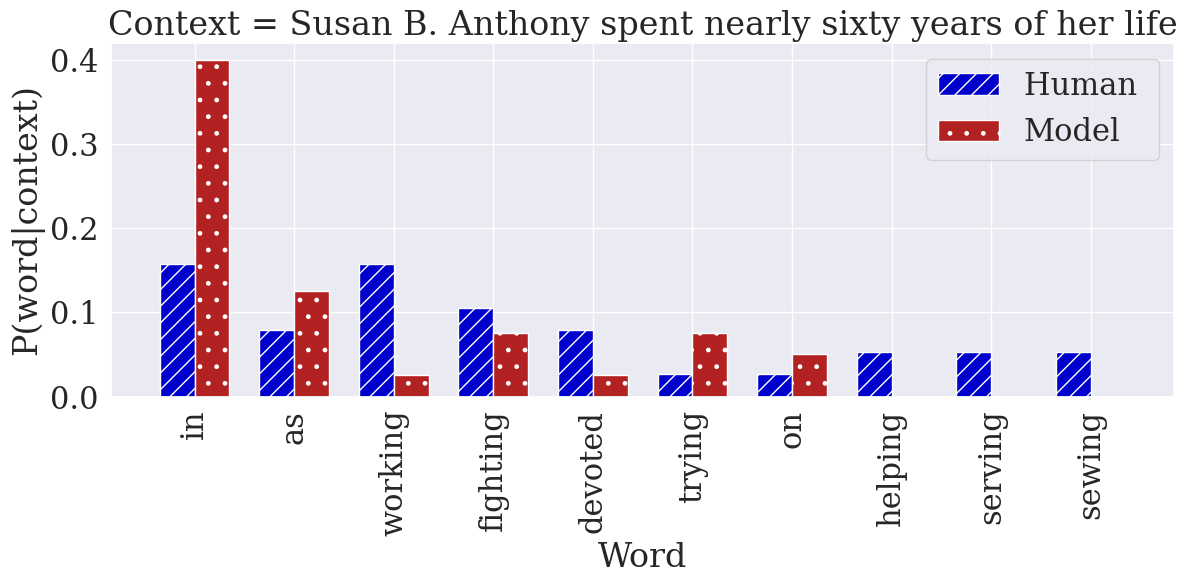

In [30]:
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as patches
import textwrap
plt.rcParams["font.family"] = "serif"
plt.rcParams["hatch.color"] = "black"

def plot_human_model_distr2(human_samples, model_samples, context, tvd_human, tvd_human_model):
    """
    Visualizes the word samples from humans and a model as a bar plot of categorical distributions with two bars next to each other.

    Args:
    - human_samples (list): List of words sampled from humans.
    - model_samples (list): List of words sampled from a model.
    - context (str): Context for the plot title.
    - tvd_human (float): Total variation distance for human samples.
    - tvd_human_model (float): Total variation distance between human and model samples.

    Returns:
    - None (displays the plot)
    """
    # Count word occurrences in human and model samples
    human_counts = Counter(human_samples)
    model_counts = Counter(model_samples)

    # Get unique words
    all_words = sorted(set(human_counts.keys()).union(set(model_counts.keys())))

    # Calculate total counts
    total_human = sum(human_counts.values())
    total_model = sum(model_counts.values())

    # Calculate probabilities for human and model samples
    human_probs = [human_counts[word] / total_human if word in human_counts else 0 for word in all_words]
    model_probs = [model_counts[word] / total_model if word in model_counts else 0 for word in all_words]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Width of each bar
    bar_width = 0.35

    # Indices for x-axis (word positions)
    x_indices = range(len(all_words))

    # Plot human samples as the first set of bars
    ax.bar(x_indices, human_probs, width=bar_width, label='Human', color='mediumblue', hatch='//')

    # Plot model samples as the second set of bars (shifted by bar_width)
    ax.bar([i + bar_width for i in x_indices], model_probs, width=bar_width, label='Model', color='firebrick',  hatch='.')

    # Set labels, title, and legend
    ax.set_xlabel('Word')
    ax.set_ylabel('P(word|context)')
    # Add the caption below the plot
    caption = f'Context = {context}'
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=100))  # Adjust the width as needed
    ax.title.set_text(wrapped_caption)
    ax.set_xticks([i + bar_width / 2 for i in x_indices])  # Center x ticks between bars
    ax.set_xticklabels(all_words, rotation=90, ha='center')  # Rotate x labels for better readability
    # ax.legend([f'Human {round(tvd_human, 2)} ', f'Model { round(tvd_human_model, 2)}', f'Model_ft0 { round(tvd_human_ft, 2)}'], loc='upper right')
    ax.legend([f'Human', f'Model'], loc='upper right')

    # Show plot
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.savefig('introduction_distribution.pdf', format="pdf",bbox_inches='tight')
    plt.show()

import matplotlib.pyplot as plt
from collections import Counter
import textwrap

plt.rcParams["font.family"] = "serif"
plt.rcParams["hatch.color"] = "black"

def plot_human_model_distrX(human_samples, model_samples, context, tvd_human, tvd_human_model):
    """
    Visualizes the word samples from humans and a model as a bar plot of categorical distributions with two bars next to each other.

    Args:
    - human_samples (list): List of words sampled from humans.
    - model_samples (list): List of words sampled from a model.
    - context (str): Context for the plot title.
    - tvd_human (float): Total variation distance for human samples.
    - tvd_human_model (float): Total variation distance between human and model samples.

    Returns:
    - None (displays the plot)
    """
    # Count word occurrences in human and model samples
    human_counts = Counter(human_samples)
    model_counts = Counter(model_samples)

    # Combine counts to get the most common words
    combined_counts = human_counts + model_counts
    top_words = [word for word, count in combined_counts.most_common(10)]

    # Calculate total counts
    total_human = sum(human_counts.values())
    total_model = sum(model_counts.values())

    # Calculate probabilities for human and model samples
    human_probs = [human_counts[word] / total_human if word in human_counts else 0 for word in top_words]
    model_probs = [model_counts[word] / total_model if word in model_counts else 0 for word in top_words]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Width of each bar
    bar_width = 0.35

    # Indices for x-axis (word positions)
    x_indices = range(len(top_words))

    # Plot human samples as the first set of bars
    ax.bar(x_indices, human_probs, width=bar_width, label='Human', color='mediumblue', hatch='//')

    # Plot model samples as the second set of bars (shifted by bar_width)
    ax.bar([i + bar_width for i in x_indices], model_probs, width=bar_width, label='Model', color='firebrick', hatch='.')

    # Set labels, title, and legend
    ax.set_xlabel('Word')
    ax.set_ylabel('P(word|context)')
    # Add the caption below the plot
    caption = f'Context = {context}'
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=100))  # Adjust the width as needed
    ax.title.set_text(wrapped_caption)
    ax.set_xticks([i + bar_width / 2 for i in x_indices])  # Center x ticks between bars
    ax.set_xticklabels(top_words, rotation=90, ha='center')  # Rotate x labels for better readability
    ax.legend([f'Human ', f'Model'], loc='upper right')

    # Show plot
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.savefig('top10_introduction_distribution.pdf', format="pdf",bbox_inches='tight')

    plt.show()



# Example usage:
human_samples = ['apple', 'banana', 'apple', 'orange', 'apple', 'orange', 'banana']
model_samples = ['apple', 'orange', 'banana', 'banana', 'apple', 'banana']
context = 'hoi'
tvd_human = 0.3
tvd_human_model = 0.4

test_data_c_lens = []
test_data_next_words = []
h_entropy = []

test_data_keys = []
for key in test_data.keys():
    test_data_keys.append(key)




# HIGH ENTROPY AND FT PERFORMING BETTER
with open('results/ft_fold0_samples.json') as json_file:
    samples_fold0 = json.load(json_file)

with open('results/gpt2_samples_tvd.json') as json_file:
    gpt2_samples_tvd = json.load(json_file)

with open('results/tvd_values_kfold_finetunes.json') as json_file:
    tvd_finetuned = json.load(json_file)

tvd_human_model = gpt2_samples_tvd['tvd_human_model']
gpt2_human_human_tvd_values = gpt2_samples_tvd['tvd_human_human']
gpt2_model_samples =  gpt2_samples_tvd['model_samples']
tvd_model_ft0 = tvd_finetuned['0']['tvd_human_model']

# for i in range(3, 10):
i =9
tvd_value_human_model = tvd_human_model[i] # baseline human model
# tvd_value_human_ft =tvd_model_ft0[i] # human vs ft model
tvd_value_human = gpt2_human_human_tvd_values[i]  # human human


context = ' '.join(test_data[test_data_keys[i]]['context'])

# plot_human_model_distr2(samples_fold0['human_samples'][i], gpt2_model_samples[i], context, tvd_value_human, tvd_value_human_model)
plot_human_model_distrX(samples_fold0['human_samples'][i], gpt2_model_samples[i], context, tvd_value_human, tvd_value_human_model)

# plot_human_model_distr2(human_samples, model_samples, context, tvd_human, tvd_human_model)


In [31]:
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as patches
import textwrap
plt.rcParams["font.family"] = "serif"
plt.rcParams["hatch.color"] = "black"

def plot_human_model_distr3(human_samples, model_samples, model_ft0_samples, context, tvd_human, tvd_human_model, tvd_human_ft, title):
    """
    Visualizes the word samples from humans and two models as a bar plot of categorical distributions with three bars next to each other.

    Args:
    - human_samples (list): List of words sampled from humans.
    - model_samples (list): List of words sampled from a model.
    - model_ft0_samples (list): List of words sampled from another model.
    - context (str): Context for the plot title.
    - tvd (float): Total variation distance.

    Returns:
    - None (displays the plot)
    """
    # Count word occurrences in human, model, and model_ft0 samples
    human_counts = Counter(human_samples)
    model_counts = Counter(model_samples)
    model_ft0_counts = Counter(model_ft0_samples)

    # Get unique words
    all_words = sorted(set(human_counts.keys()).union(set(model_counts.keys())).union(set(model_ft0_counts.keys())))

    # Calculate total counts
    total_human = sum(human_counts.values())
    total_model = sum(model_counts.values())
    total_model_ft0 = sum(model_ft0_counts.values())

    # Calculate probabilities for human, model, and model_ft0 samples
    human_probs = [human_counts[word] / total_human if word in human_counts else 0 for word in all_words]
    model_probs = [model_counts[word] / total_model if word in model_counts else 0 for word in all_words]
    model_ft0_probs = [model_ft0_counts[word] / total_model_ft0 if word in model_ft0_counts else 0 for word in all_words]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Width of each bar
    bar_width = 0.25

    # Indices for x-axis (word positions)
    x_indices = range(len(all_words))

    # # Plot human samples as the first set of bars
    # for i, (prob, word) in enumerate(zip(human_probs, all_words)):
    #     ax.add_patch(patches.Rectangle((i - bar_width, 0), bar_width, prob, color='skyblue', hatch='///'))

    # # Plot model samples as the second set of bars (shifted by bar_width)
    # for i, (prob, word) in enumerate(zip(model_probs, all_words)):
    #     ax.add_patch(patches.Rectangle((i, 0), bar_width, prob, color='orange', hatch='xxx'))

    # # Plot model_ft0 samples as the third set of bars (shifted by 2 * bar_width)
    # for i, (prob, word) in enumerate(zip(model_ft0_probs, all_words)):
    #     ax.add_patch(patches.Rectangle((i + bar_width, 0), bar_width, prob, color='green', hatch='---'))

    # Plot human samples as the first set of bars
    ax.bar(x_indices, human_probs, width=bar_width, label='Human', color='mediumblue', hatch='//')

    # Plot model samples as the second set of bars (shifted by bar_width)
    ax.bar([i + bar_width for i in x_indices], model_probs, width=bar_width, label='Model', color='firebrick',  hatch='.')

    # Plot model samples as the second set of bars (shifted by bar_width)
    ax.bar([i + 2*bar_width for i in x_indices], model_ft0_probs, width=bar_width, label='FT Model', color='green',  hatch='//')

    # # Set the background color
    # fig.patch.set_facecolor('lightgrey')  # Set figure background color
    # ax.set_facecolor('lightgrey')  # Set axes background color


    # Set labels, title, and legend
    ax.set_xlabel('Word', fontsize=22)
    ax.set_ylabel('P(word|context)', fontsize=22)
    # ax.set_title(f'P(w|c) for c = {context}')
    # Add the caption below the plot
    font_properties = {'fontsize': 22, 'color': 'black'}  # Customize as needed


    caption = f'Context = {context}'
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=70))  # Adjust the width as needed
    ax.set_title(wrapped_caption, fontdict=font_properties)
    ax.set_xticks(x_indices)  # Set x ticks at word positions
    ax.set_xticklabels(all_words, rotation=90, ha='center', fontsize=15)  # Rotate x labels for better readability
    ax.legend([f'Human, tvd: {round(tvd_human, 2)} ', f'GPT2, tvd: { round(tvd_human_model, 2)}', f'GPT2 FT_s, tvd: { round(tvd_human_ft, 2)}'], loc='upper right', fontsize=18)

    # Show plot
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.savefig(title, format="pdf",bbox_inches='tight')
    plt.show()

# Example usage:
human_samples = ['apple', 'banana', 'apple', 'orange', 'apple', 'orange', 'banana']
model_samples = ['apple', 'orange', 'banana', 'banana', 'apple', 'banana']
model_ft0_samples = ['banana', 'orange', 'apple', 'banana', 'apple', 'banana', 'apple']
context = 'hoi'
tvd = 0.3
tvd2 = 0.4
tvd3 = 0.6
# plot_human_model_distr3(human_samples, model_samples, model_ft0_samples, context, tvd, tvd2, tvd3)


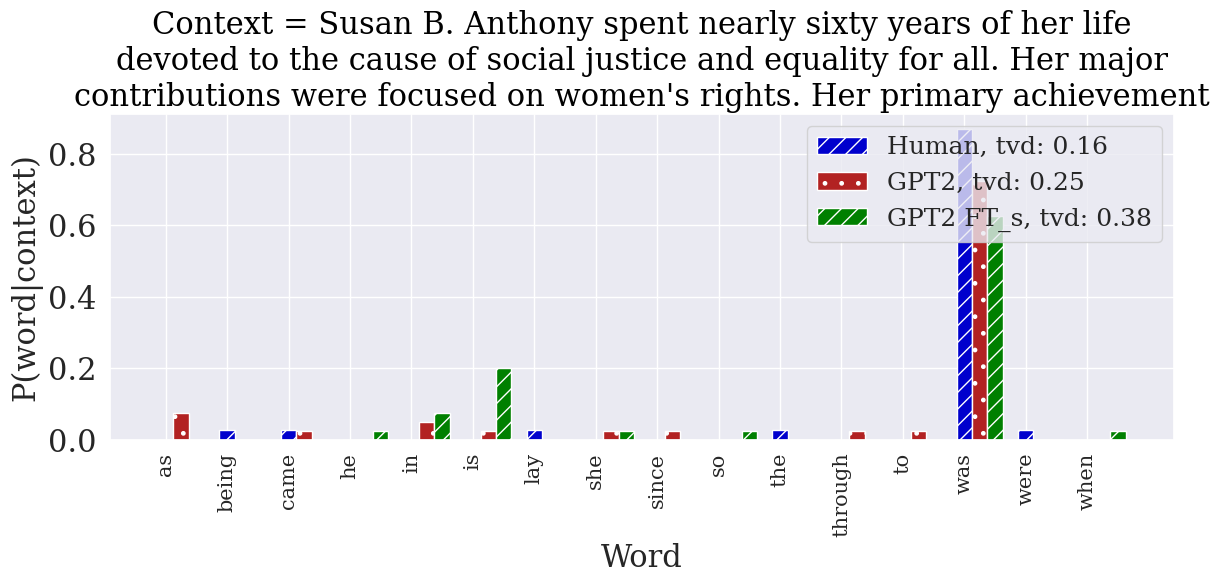

In [32]:
i = 31
tvd_value_human_model = tvd_human_model[i] # baseline human model
tvd_value_human_ft =tvd_model_ft0[i] # human vs ft model
tvd_value_human = gpt2_human_human_tvd_values[i]  # human human


context = ' '.join(test_data[test_data_keys[i]]['context'])
context = context.replace("Õ", "'")
# print(context.replace("Õ", "'"))

plot_human_model_distr3(samples_fold0['human_samples'][i], gpt2_model_samples[i], samples_fold0['model_samples'][i], context,tvd_value_human, tvd_value_human_model, tvd_value_human_ft, 'distr2.pdf' )


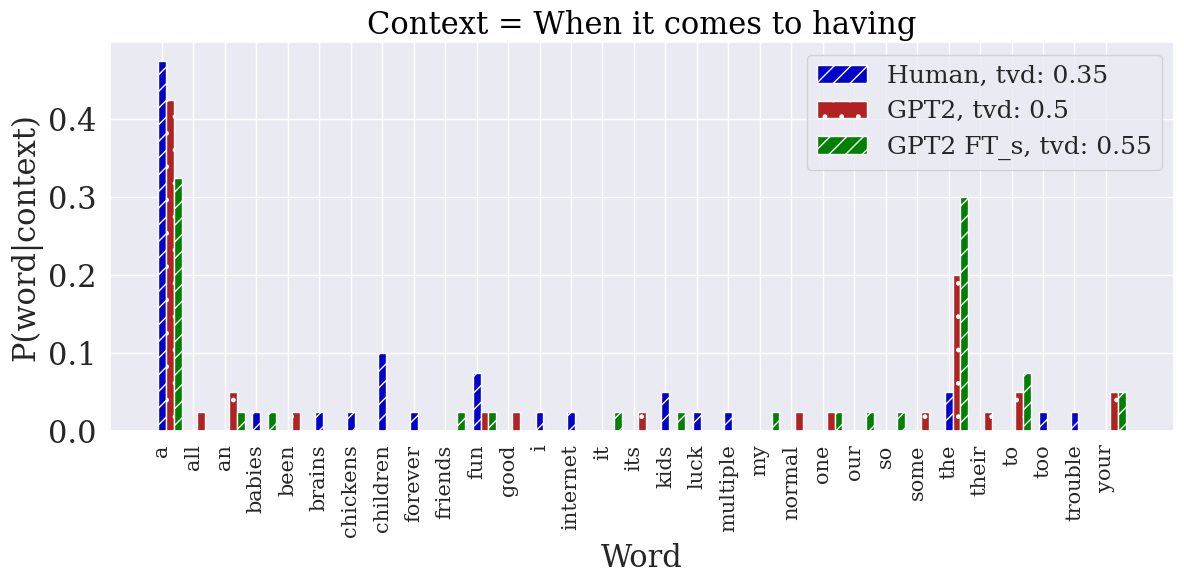

In [33]:
i = 404
tvd_value_human_model = tvd_human_model[i] # baseline human model
tvd_value_human_ft =tvd_model_ft0[i] # human vs ft model
tvd_value_human = gpt2_human_human_tvd_values[i]  # human human


context = ' '.join(test_data[test_data_keys[i]]['context'])
context = context.replace("Õ", "'")
# print(context.replace("Õ", "'"))

plot_human_model_distr3(samples_fold0['human_samples'][i], gpt2_model_samples[i], samples_fold0['model_samples'][i], context,tvd_value_human, tvd_value_human_model, tvd_value_human_ft, 'distr1.pdf' )
